<a href="https://colab.research.google.com/github/Jhorn-spec/Featcraft/blob/main/Animal_Wildlife_Classification_using_Transfer_Learning_and_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the necessary libraries

In [ ]:
import os
import shutil
import random
from zipfile import ZipFile, BadZipfile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.optimizers import Adam

Downloading the Dataset from Kaggle

In [ ]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import jovian

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download biancaferreira/african-wildlife

Dataset URL: https://www.kaggle.com/datasets/biancaferreira/african-wildlife
License(s): unknown
african-wildlife.zip: Skipping, found more recently modified local copy (use --force to force download)


Extracting the Dataset in Zip format

In [ ]:
with ZipFile("african-wildlife.zip", "r") as zip_ref:
  zip_ref.extractall()

In [ ]:
class_names = ["buffalo", "elephant", "rhino", "zebra"]

Creating the Images Folder

In [ ]:
try:
  os.makedirs("images")
except FileExistsError:
  pass

Creating the Subfolders in Images

In [ ]:
for i in class_names:
  try:
    os.makedirs(os.path.join("images", i))
  except FileExistsError:
    pass

Transferring all Images to their Respective Folders

In [ ]:
for i in range(len(class_names)):
  for filename in os.listdir(class_names[i]):
    full_path = os.path.join(class_names[i], filename)
    shutil.copy(full_path, os.path.join("images", class_names[i], filename))
    # if filename.split(".")[-1] == "jpg":


Visualizing Each Class of the Dataset

In [ ]:
def load_images_and_labels(base_folder):
    animal_types = ['buffalo', 'elephant', 'rhino', 'zebra']
    images = {animal: [] for animal in animal_types}
    labels = {animal: [] for animal in animal_types}
    categories = []                                                     # added
    for animal in animal_types:
        animal_folder = os.path.join(base_folder, animal)
        for filename in os.listdir(animal_folder):
            if filename.endswith('.jpg'):
                path = os.path.join(animal_folder, filename)
                image = cv2.imread(path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    label_file = filename.replace('.jpg', '.txt')
                    label_path = os.path.join(animal_folder, label_file)

                    with open(label_path, 'r') as file:
                        boxes = file.readlines()

                    images[animal].append(image)
                    labels[animal].append(boxes)
                    categories.append(animal)
    return images, labels, categories

In [ ]:
# Load and plot images
base_dir = r"/content/images"
images, labels, categories = load_images_and_labels(base_dir)

In [ ]:
def show_image_with_boxes(image, boxes, category, ax):
    ax.imshow(image)
    for box in boxes:
        parts = box.strip().split()
        x_center, y_center, width, height = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
        x = (x_center - width / 2) * image.shape[1]
        y = (y_center - height / 2) * image.shape[0]
        rect = patches.Rectangle((x, y), width * image.shape[1], height * image.shape[0], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.set_title(category)
    ax.axis('off')

In [ ]:
def plot_category_images(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(20, 5))
    if len(axs) != len(images):
        axs = [axs]  # in case there's only one category plotted, matplotlib doesn't return an array of axes
    for ax, (category, imgs) in zip(axs, images.items()):
        show_image_with_boxes(imgs[0], labels[category][0], category, ax)
    plt.show()

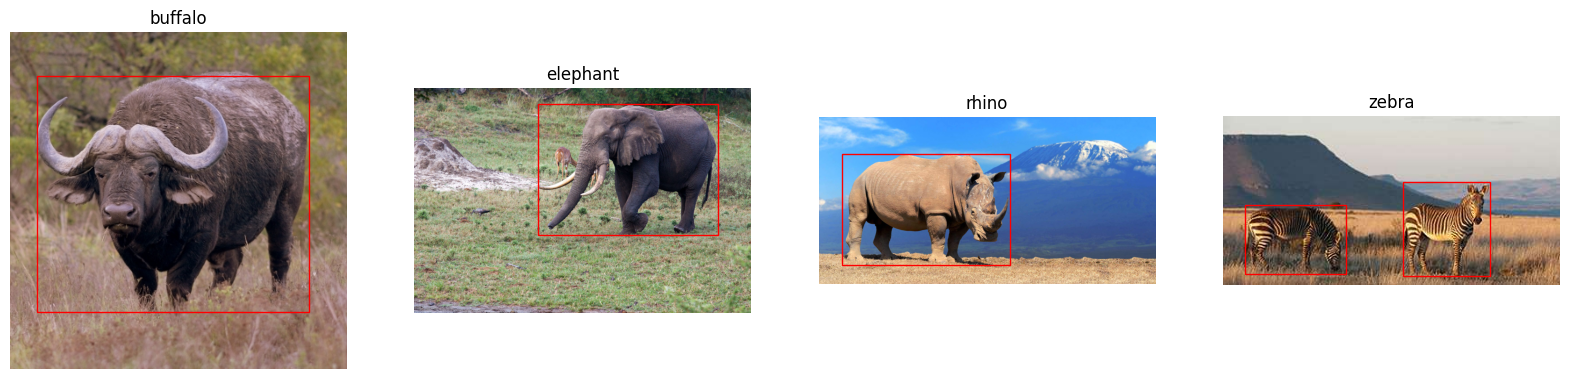

In [ ]:
plot_category_images(images, labels)

Distribution of Each Class

In [ ]:
print("Total images loaded:", len(images))
print("Category distribution:")
for category in set(categories):
    print(f"{category}: {categories.count(category)}")


Total images loaded: 4
Category distribution:
rhino: 375
elephant: 375
buffalo: 375
zebra: 376


##EXPLORATORY DATA ANALYSIS

Distribution of the Classes of Animals

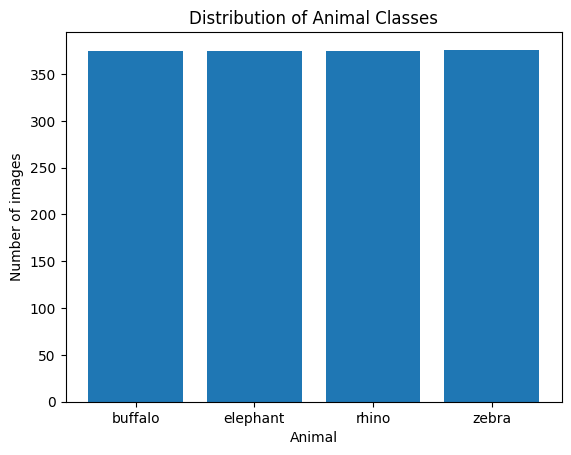

In [ ]:
def plot_class_distribution(categories):
    class_counts = {}
    for category in categories:
        if category in class_counts:
            class_counts[category] += 1
        else:
            class_counts[category] = 1

    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Animal')
    plt.ylabel('Number of images')
    plt.title('Distribution of Animal Classes')
    plt.show()

# Assuming images, labels, and categories are loaded from the modified load_images_and_labels function
base_dir = r"/content/images"
#images, labels, categories = load_images_and_labels(base_dir)
plot_class_distribution(categories)

Distribution of Image Widths and Heights

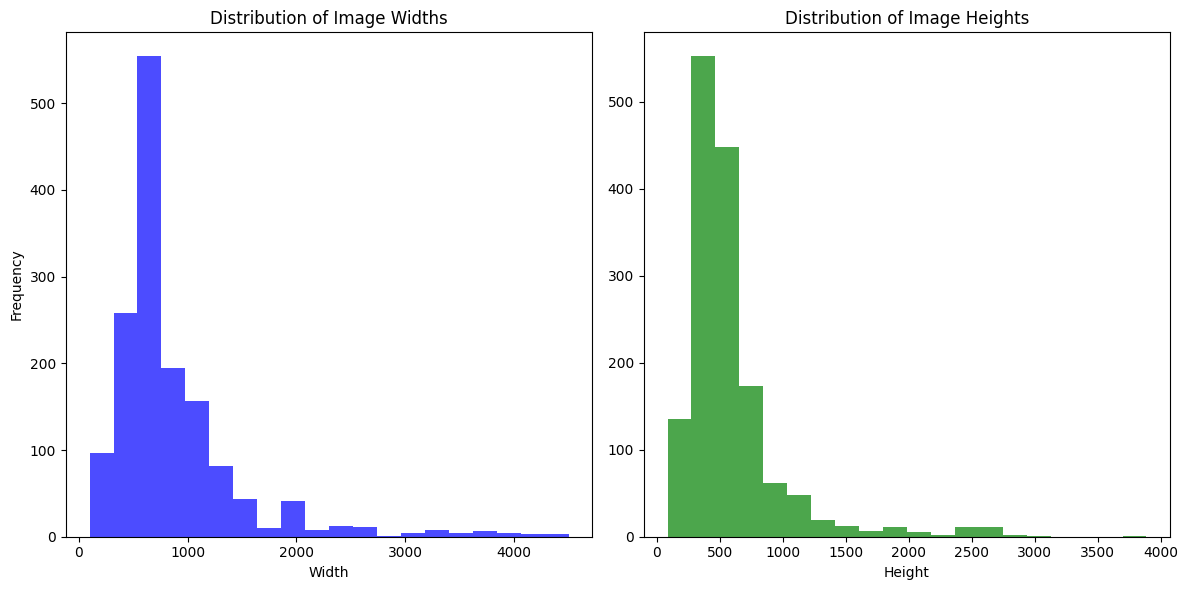

In [ ]:
def load_images_and_labels(base_folder):
    animal_types = ['buffalo', 'elephant', 'rhino', 'zebra']
    images = []
    labels = []
    categories = []
    for animal in animal_types:
        animal_folder = os.path.join(base_folder, animal)
        for filename in os.listdir(animal_folder):
            if filename.endswith('.jpg'):
                path = os.path.join(animal_folder, filename)
                image = cv2.imread(path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    label_file = filename.replace('.jpg', '.txt')
                    label_path = os.path.join(animal_folder, label_file)

                    with open(label_path, 'r') as file:
                        boxes = file.readlines()

                    images.append(image)
                    labels.append(boxes)
                    categories.append(animal)
    return images, labels, categories

def plot_image_dimensions(images):
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.hist(widths, bins=20, color='blue', alpha=0.7)
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width')
    plt.ylabel('Frequency')

    plt.subplot(122)
    plt.hist(heights, bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height')

    plt.tight_layout()
    plt.show()

# Load the images and labels
base_dir = "/content/images"
images, labels, categories = load_images_and_labels(base_dir)

# Plot dimensions
plot_image_dimensions(images)

Frequency Dstribution of Number of Objects per Image

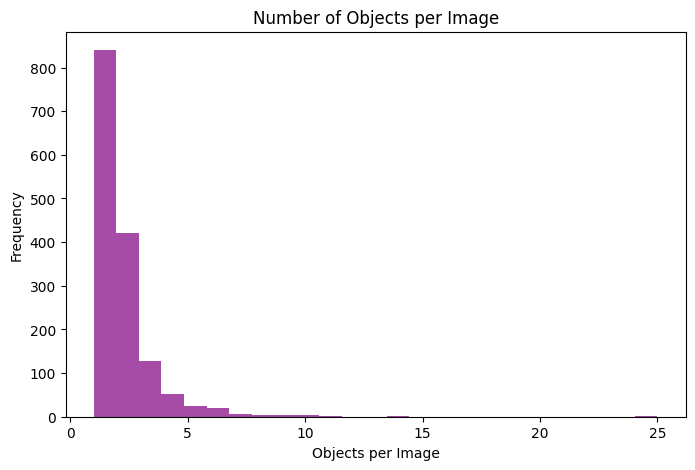

In [ ]:
def plot_objects_per_image(labels):
    num_objects = [len(label) for label in labels]

    plt.figure(figsize=(8, 5))
    plt.hist(num_objects, bins=max(num_objects), color='purple', alpha=0.7)
    plt.title('Number of Objects per Image')
    plt.xlabel('Objects per Image')
    plt.ylabel('Frequency')
    plt.show()

# Assuming labels are loaded
plot_objects_per_image(labels)

Frequency Dstribution of Bounding Box Area

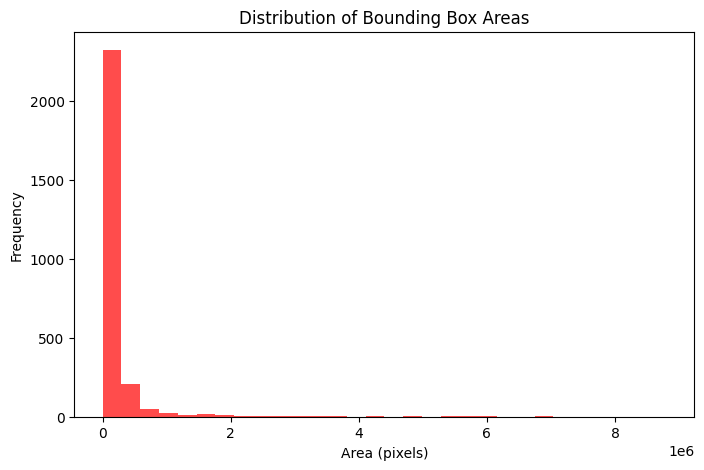

In [ ]:
def plot_bbox_sizes(labels, images):
    bbox_areas = []
    for label, image in zip(labels, images):
        for box in label:
            parts = box.strip().split()
            _, x, y, w, h = map(float, parts)
            width_pixels = w * image.shape[1]
            height_pixels = h * image.shape[0]
            bbox_areas.append(width_pixels * height_pixels)

    plt.figure(figsize=(8, 5))
    plt.hist(bbox_areas, bins=30, color='red', alpha=0.7)
    plt.title('Distribution of Bounding Box Areas')
    plt.xlabel('Area (pixels)')
    plt.ylabel('Frequency')
    plt.show()


plot_bbox_sizes(labels, images)

Visualizing Annotations

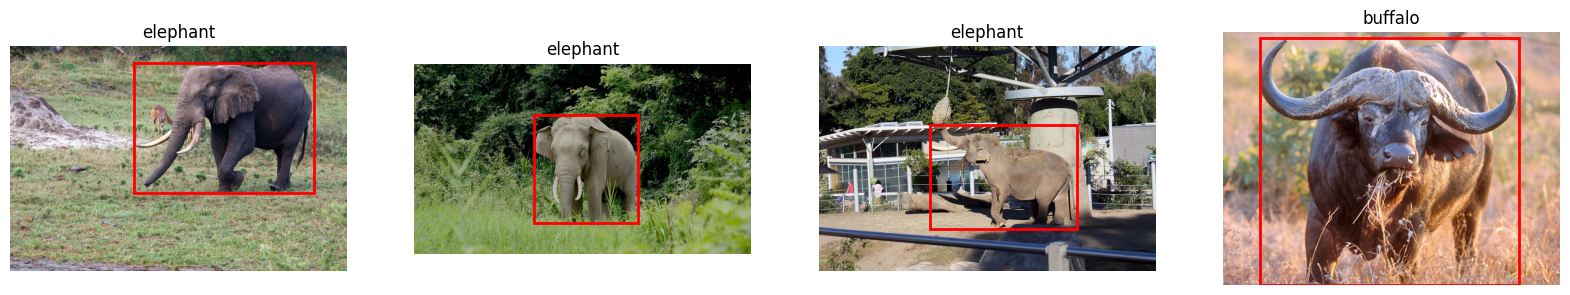

In [ ]:
def visualize_annotations(images, labels, categories, num_samples=4):
    indices = random.sample(range(len(images)), num_samples)
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))

    for i, idx in enumerate(indices):
        image = images[idx]
        label = labels[idx]
        category = categories[idx]
        ax = axs[i]
        ax.imshow(image)
        for box in label:
            parts = box.strip().split()
            x_center, y_center, width, height = map(float, parts[1:])
            x = (x_center - width / 2) * image.shape[1]
            y = (y_center - height / 2) * image.shape[0]
            rect = patches.Rectangle((x, y), width * image.shape[1], height * image.shape[0], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        ax.set_title(category)
        ax.axis('off')
    plt.show()


visualize_annotations(images, labels, categories, num_samples=4)


##Data Splitting

Training Data

In [ ]:
training_data = image_dataset_from_directory(
    directory=r"/content/images",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.3,
    subset="training",
    seed = 1
)

Found 1504 files belonging to 4 classes.
Using 1053 files for training.


Validation Data

In [ ]:
validation_data = image_dataset_from_directory(
    directory = r"/content/images",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
    validation_split=0.2,
    subset="validation",
    seed = 1
)

Found 1504 files belonging to 4 classes.
Using 300 files for validation.


Testing Data

In [ ]:
test_data = image_dataset_from_directory(
    directory = r"/content/images",
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
    validation_split=0.1,
    subset="validation",
    seed = 1
)

Found 1504 files belonging to 4 classes.
Using 150 files for validation.


Data Preprocessing and Augmentation

In [ ]:
from tensorflow.image import flip_left_right, adjust_brightness, adjust_contrast
from keras.layers import Rescaling

Image Augmentation

In [ ]:
def augment(image, label):
    image = flip_left_right(image)
    image = adjust_brightness(image, delta=0.1)
    image = adjust_contrast(image, contrast_factor = 1.75)
    return (image, label)

Image Rescaling

In [ ]:
# training_data = training_data.map(lambda x,y: (x/255, y))
# validation_data = validation_data.map(lambda x,y: (x/255, y))
# test_data = test_data.map(lambda x,y: (x/255, y))

In [ ]:
training_data = training_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

Data Optimization

In [ ]:
training_data = training_data.prefetch(tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

Building the Model

In [ ]:
model = keras.Sequential([
    layers.Conv2D(16, (3,3), 1, activation = "relu", input_shape = (256, 256, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), 1, activation = "relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(16, (3,3), 1, activation = "relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(256, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])

In [ ]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

Training the Model

In [ ]:
history = model.fit(
    training_data,
    validation_data = validation_data,
    epochs = 20,
)

Epoch 1/20
33/33 [==============================] - 18s 332ms/step - loss: 49.9430 - accuracy: 0.3542 - val_loss: 1.3471 - val_accuracy: 0.7667
Epoch 2/20
33/33 [==============================] - 12s 299ms/step - loss: 0.9679 - accuracy: 0.6439 - val_loss: 1.3773 - val_accuracy: 0.5600
Epoch 3/20
33/33 [==============================] - 12s 325ms/step - loss: 0.4856 - accuracy: 0.8310 - val_loss: 1.2683 - val_accuracy: 0.6133
Epoch 4/20
33/33 [==============================] - 12s 271ms/step - loss: 0.1312 - accuracy: 0.9668 - val_loss: 1.3122 - val_accuracy: 0.5833
Epoch 5/20
33/33 [==============================] - 12s 302ms/step - loss: 0.0957 - accuracy: 0.9820 - val_loss: 1.0730 - val_accuracy: 0.6567
Epoch 6/20
33/33 [==============================] - 13s 355ms/step - loss: 0.0331 - accuracy: 0.9943 - val_loss: 1.3127 - val_accuracy: 0.5700
Epoch 7/20
33/33 [==============================] - 12s 293ms/step - loss: 0.0329 - accuracy: 0.9886 - val_loss: 1.4222 - val_accuracy: 0.550

Performance Plot

In [ ]:
history_df = pd.DataFrame(history.history)

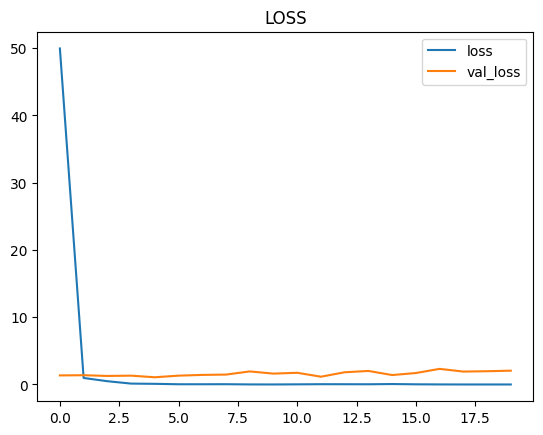

In [ ]:
history_df.loc[:, ["loss", "val_loss"]].plot()
plt.title("LOSS")
plt.show()

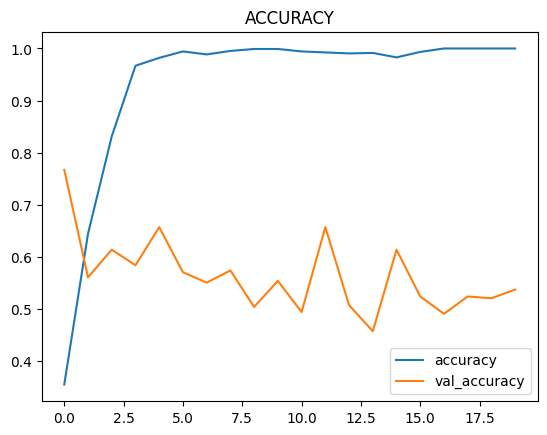

In [ ]:
history_df.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.title("ACCURACY")
plt.show()

Model Evaluation on the Test Data Using Loss and Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_data)
print(f"The accuracy of the model on the testing data --> {round(accuracy, 3)} and the loss --> {round(loss, 3)}")

5/5 [==============================] - 2s 346ms/step - loss: 1.6813 - accuracy: 0.5600
The accuracy of the model on the testing data --> 0.56 and the loss --> 1.681


Applying Transfer Learning to Improve Model

In [ ]:
from keras.applications import EfficientNetV2L

In [ ]:
model = EfficientNetV2L(
    weights="imagenet",
    include_top = False,
    input_shape= (256, 256, 3)
)
for layer in model.layers:
    layer.trainable = False

473176280/473176280 [==============================] - 7s 0us/step


Applying Callbacks: EarlyStopping

In [ ]:
call_backs = keras.callbacks.EarlyStopping(
    patience= 3,
    monitor = "val_loss"
)

Creating the New Model with Transfer Learning

In [ ]:
tf_model = keras.Sequential([
    model,
    layers.Conv2D(32,(3,3), 1, activation="relu"),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation="softmax")
])

In [ ]:
tf_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"],
)

Training the model

In [ ]:
history = tf_model.fit(
    training_data,
    epochs=20,
    validation_data=validation_data,
    # callbacks=[call_backs],
)

Epoch 1/20
33/33 [==============================] - 77s 1s/step - loss: 1.1351 - accuracy: 0.8490 - val_loss: 0.1013 - val_accuracy: 0.9867
Epoch 2/20
33/33 [==============================] - 23s 652ms/step - loss: 0.1410 - accuracy: 0.9696 - val_loss: 0.0542 - val_accuracy: 0.9867
Epoch 3/20
33/33 [==============================] - 23s 625ms/step - loss: 0.1644 - accuracy: 0.9668 - val_loss: 0.0584 - val_accuracy: 0.9933
Epoch 4/20
33/33 [==============================] - 23s 646ms/step - loss: 0.0735 - accuracy: 0.9820 - val_loss: 0.0642 - val_accuracy: 0.9900
Epoch 5/20
33/33 [==============================] - 23s 630ms/step - loss: 0.0913 - accuracy: 0.9858 - val_loss: 0.0478 - val_accuracy: 0.9933
Epoch 6/20
33/33 [==============================] - 22s 622ms/step - loss: 0.0827 - accuracy: 0.9791 - val_loss: 0.1056 - val_accuracy: 0.9900
Epoch 7/20
33/33 [==============================] - 23s 648ms/step - loss: 0.1356 - accuracy: 0.9772 - val_loss: 0.2379 - val_accuracy: 0.9767
Ep

Performance Plot

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,1.135093,0.849003,0.101292,0.986667
1,0.141006,0.969611,0.054176,0.986667
2,0.164379,0.966762,0.058437,0.993333
3,0.073549,0.981956,0.064239,0.990000
4,0.091263,0.985755,0.047773,0.993333


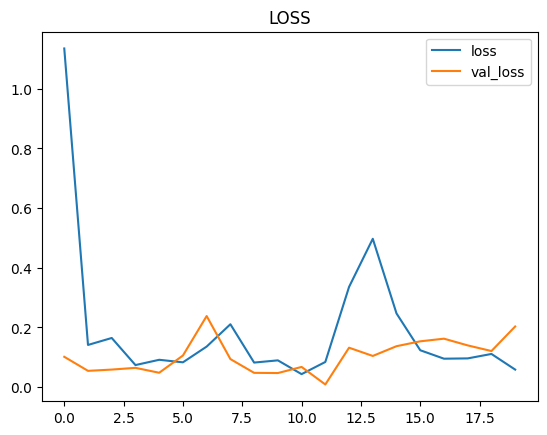

In [ ]:
history_df.loc[:, ["loss", "val_loss"]].plot()
plt.title("LOSS")
plt.show()

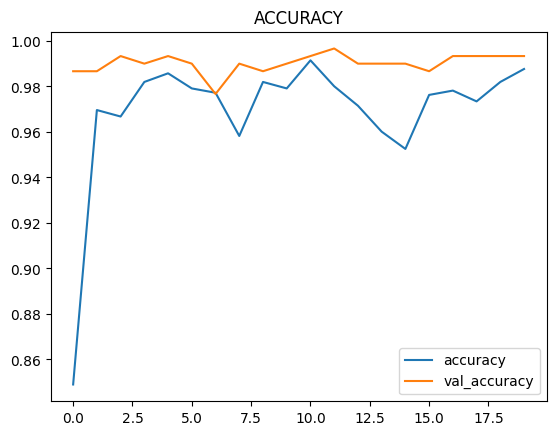

In [ ]:
history_df.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.title("ACCURACY")
plt.show()

Model Evaluation on Test Data Using Loss and Accuracy

In [ ]:
loss, accuracy = tf_model.evaluate(test_data)
print(f"The accuracy of the tf_model on testing data --> {round(accuracy, 3)} and the loss --> {round(loss, 3)}")

5/5 [==============================] - 9s 2s/step - loss: 0.0015 - accuracy: 1.0000
The accuracy of the tf_model on testing data --> 1.0 and the loss --> 0.001


Testing the Model

In [ ]:
def test_model(img_path):
    img = cv2.imread(img_path)

    # Resizing the image
    resized_image = tf.image.resize(img, (256,256))

    # Reshape it or wrap it with the initial images shape
    final_img = np.expand_dims(resized_image, 0)

    # Predicting the image
    prediction = tf_model.predict(final_img)
    prediction = np.argmax(prediction)
    animal_name = class_names[prediction]
    return f"Animal ---> {animal_name}"

Buffalo test

In [ ]:
test_model(r"/content/buffalotest.jpg")

1/1 [==============================] - 9s 9s/step


'Animal ---> buffalo'

Elephant test

In [ ]:
test_model(r"/content/elephanttest.jpg")

1/1 [==============================] - 0s 88ms/step


'Animal ---> elephant'

Rhino test

In [ ]:
test_model(r"/content/rhinotest.jpg")

1/1 [==============================] - 0s 177ms/step


'Animal ---> rhino'

Zebra test

In [ ]:
test_model(r"/content/zebratest.jpg")

1/1 [==============================] - 0s 92ms/step


'Animal ---> zebra'